In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

In [274]:

RELEVANT_FEATURES = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',  # extremly discriminative!
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'popularity',
]


def get_tracks_and_labels() -> pd.DataFrame:
    tracks = pd.read_csv('../songs_filtered.csv')
    tracks_relevant = tracks[RELEVANT_FEATURES]

    n_features = tracks_relevant.values.shape[1] - 1

    X = tracks_relevant.values[:, :n_features]
    y = tracks_relevant.values[:, n_features]

    return (X, y)

In [275]:
X, y = get_tracks_and_labels()

In [330]:
y_bins = np.digitize(y, [0, 33, 66, 100])
y_one_hot = label_binarize(y_bins, classes=[1, 2, 3])

In [331]:
y_bins

array([3, 3, 2, ..., 2, 2, 2])

In [332]:
y_one_hot

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [333]:
np.unique(y_bins, return_counts=True)

(array([1, 2, 3]), array([693633,  60261,   2788]))

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, train_size=0.8)
    
## ML Pipeline
pipe = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(
    GridSearchCV(
        LogisticRegression(),
        param_grid={
        'penalty': ['l2'],
        'class_weight': ['balanced'],
        # 'l1_ratio': [0.5],
        # 'solver': ['saga'],
        'C': np.logspace(-5, 2, 10)
        },
        cv=5,
        refit=True
    )
    )
)

In [335]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=GridSearchCV(cv=5,
                                                            estimator=LogisticRegression(),
                                                            param_grid={'C': array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
       1.66810054e+01, 1.00000000e+02]),
                                                                        'class_weight': ['balanced'],
                                                                        'penalty': ['l2']})))])

In [336]:
predictions = pipe.predict(X_test)
# confusion_matrix(y_test, predictions)


In [347]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

y_score = pipe.predict_proba(X_test)

# metrics.roc_auc_score(y_test, y_score, multi_class='ovo')

n_classes = 3

In [352]:
pipe.predict(X_test)

array([[0, 1, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [353]:
y_test

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

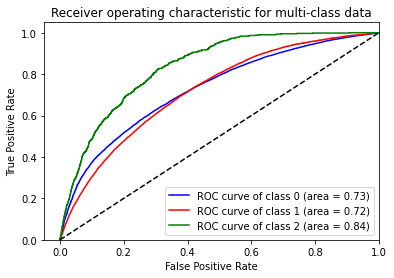

In [349]:
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

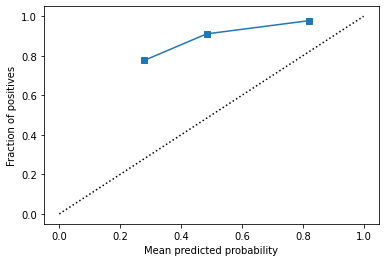

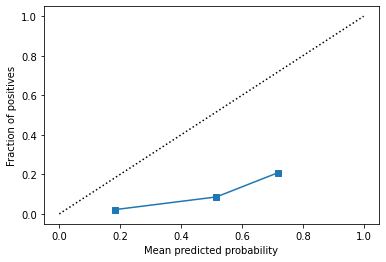

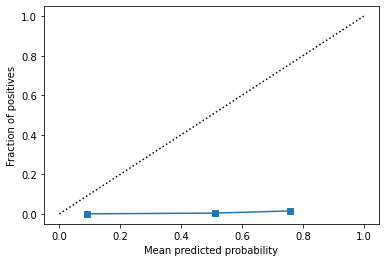

In [355]:
from itertools import cycle
prob_true = dict()
prob_pred = dict()

for i in range(n_classes):
    prob_true[i], prob_pred[i] = calibration_curve(y_test[:, i], y_score[:, i], n_bins = 3)

for i, color in zip(range(n_classes), colors):
    disp = CalibrationDisplay(prob_true[i], prob_pred[i], y_score[i])
    disp.plot()